<a href="https://colab.research.google.com/github/kevinpineda99/Proyecto_EPM/blob/main/Code_EPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reto tecnológico #10:

## Pre-proceso

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as sta
import requests
import json
import folium
from folium.plugins import HeatMap

In [2]:
epm = pd.read_csv('https://www.datos.gov.co/api/views/r9fv-awbc/rows.csv?accessType=DOWNLOAD')
epm['Motivo'].replace({'0':'#No registra motivo#'}, inplace = True)

In [3]:
epm['Fecha de registro'] = pd.to_datetime(epm['Fecha de registro'], errors='ignore', dayfirst=False)
epm['Inicio'] = pd.to_datetime(epm['Inicio'], errors='ignore', dayfirst=False)
epm['Fin'] = pd.to_datetime(epm['Fin'], errors='ignore', dayfirst=False)
epm['Fecha y hora esperada'] = pd.to_datetime(epm['Fecha y hora esperada'], errors='ignore', dayfirst=False)

In [4]:
epm.drop((epm[(epm['Horas'] == '2020-12-22T04:00:00.000') | (epm['Horas'] == '2020-12-22T11:00:00.000') | (epm['Horas'] == '2020-12-23T06:00:00.000') 
| (epm['Horas'] == '2020-12-22T06:00:00.000')].index), axis = 0, inplace = True)

In [5]:
epm.drop(epm[(epm['Fecha de registro'] == '05/21/2012')].index, axis = 0, inplace = True)
epm.drop(epm[(epm['Impacto'] == 'S16')].index, axis = 0, inplace = True)
epm['Número de instalación'].replace({'-':0}, inplace = True)

In [6]:
epm = epm.astype({'Horas' : 'float32', 'Número de instalación' : 'int32'})

## Exploración de datos

### Inspección de datos

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


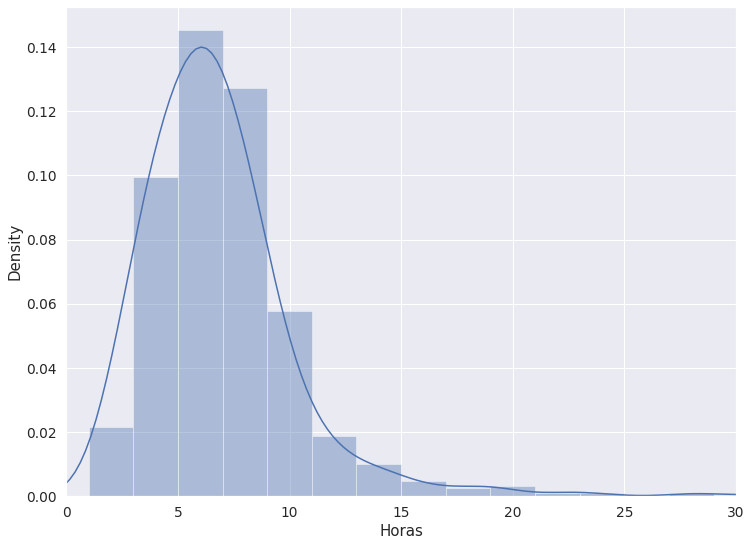

In [ ]:
f, ax = plt.subplots(figsize=(12, 9))
sns.distplot(epm['Horas'], bins = 20)
hist1 = plt.xlim(0,30)
plt.savefig("Histograma_horas.png")

In [ ]:
NA = epm.isna().sum() #Identificar valores NA
NA[NA!=0] #Solamente la columna 'Nombre del contratista' presenta valores faltantes (Solo 3)

In [ ]:
epm.dtypes

Impacto                            object
Circuito                           object
Servicio                           object
Motivo                             object
Solicita                           object
Número de instalación               int32
Municipio                          object
Dirección                          object
Nombre del responsable             object
Fecha y hora esperada      datetime64[ns]
Inicio                     datetime64[ns]
Fin                        datetime64[ns]
Horas                             float32
Estado                             object
Fecha de registro          datetime64[ns]
Explicación                        object
Barrio                             object
Nombre del contratista             object
Tipo de aviso                      object
dtype: object

In [ ]:
epm.info()

In [ ]:
epm._get_numeric_data().describe().T

### Correlación

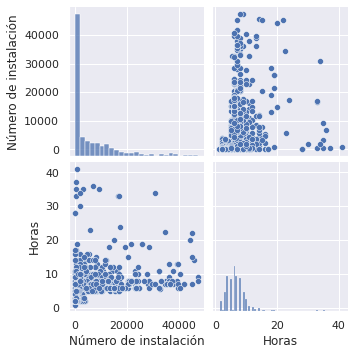

In [ ]:
cols = ['Número de instalación', 'Horas']
sns.set()
sns.pairplot(epm[cols]);
plt.savefig("Correlación_#instalaciones.png")

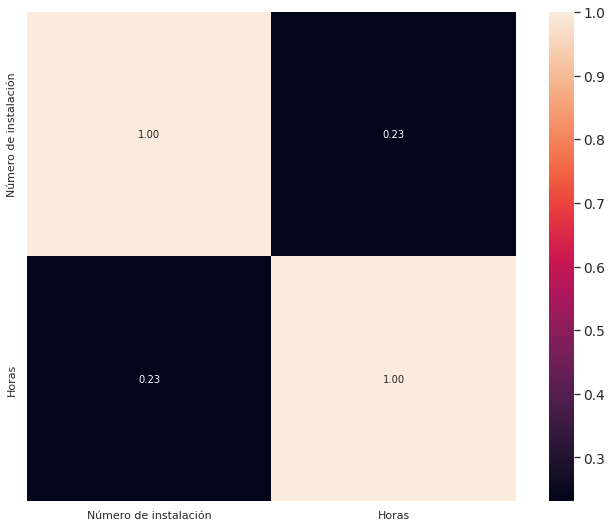

<Figure size 432x288 with 0 Axes>

In [ ]:
cm = np.corrcoef(epm[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

### Variables categorica

In [ ]:
disc_col = [i for i in epm.columns if not i in epm._get_numeric_data()]
print (disc_col)

In [ ]:
disc_col_net = ['Impacto', 'Motivo', 'Municipio', 'Nombre del responsable']
for i in disc_col_net:
    print("%10s"%i, np.unique(epm[i].dropna()))

In [ ]:
plt.figure(figsize=(40,20))
for i,c in enumerate(disc_col_net):    
    plt.subplot(2,4,i+1)
    k = epm[[c,"Horas"]].dropna()
    for v in epm[c].dropna().unique():
        sns.distplot(k.Horas[k[c]==v], label=v);
        plt.title(c)
    plt.yticks([])
    plt.legend()
    
    plt.subplot(2,4,i+5)
    vc = k[c].value_counts()
    sns.barplot(vc.index, vc.values)    
    plt.xticks(range(len(vc)), vc.index, rotation="vertical");

### Variable categorica (Contratistas)

In [ ]:
top6_contratistas = epm['Nombre del contratista '].value_counts().head(6)

In [ ]:
top6_contratistas

Ingeniería Total Ltda.                 255
Contratista: Ingeniería Total Ltda.    118
SANEAR S.A.                             41
CONSORCIO REDES IGUANÁ.                 27
Consorcio Redes Iguaná.                 27
REDYCO S.A.S.                           15
Name: Nombre del contratista , dtype: int64

In [ ]:
# sns.distplot(top6_contratistas, label=top6_contratistas.index)
plt.figure(figsize=(40,30))
plt.subplot(2,2,1)
for i in (list(top6_contratistas.index)):
    sns.distplot(epm.Horas[epm['Nombre del contratista ']==i], label=i);
plt.title('Contratistas')
plt.legend(fontsize=20)
plt.subplot(2,2,2)
sns.barplot(top6_contratistas.index, top6_contratistas.values);
plt.xticks(range(len(top6_contratistas)), top6_contratistas.index, rotation="vertical");

##Punto #1



In [ ]:
epm_by_mes = epm.groupby(pd.PeriodIndex(epm['Fecha de registro'], freq='Q-DEC'), axis=0).mean()['Horas'].sort_index(axis = 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


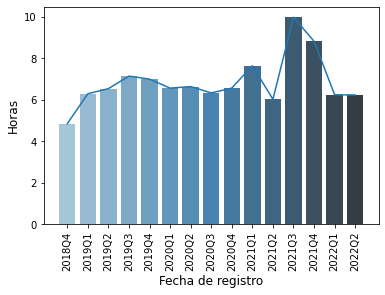

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_mes.index, epm_by_mes.values, palette="Blues_d")
plt.xticks(range(len(epm_by_mes)), epm_by_mes.index, rotation="vertical")
ax.plot(range(len(epm_by_mes)), epm_by_mes.values)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Fecha de registro', fontsize=12);

In [ ]:
epm_by_year = epm.groupby(pd.PeriodIndex(epm['Fecha de registro'], freq='Y'), axis=0).mean()['Horas'].sort_index(axis = 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


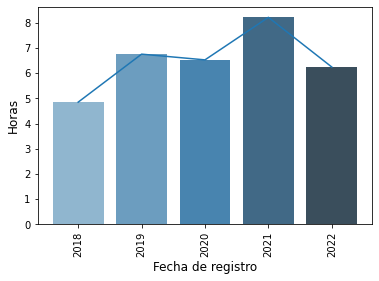

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_year.index, epm_by_year.values, palette="Blues_d")
plt.xticks(range(len(epm_by_year)), epm_by_year.index, rotation="vertical")
ax.plot(range(len(epm_by_year)), epm_by_year.values)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Fecha de registro', fontsize=12);

In [ ]:
epm_by_impacto = epm.groupby('Impacto').mean()['Horas'].sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


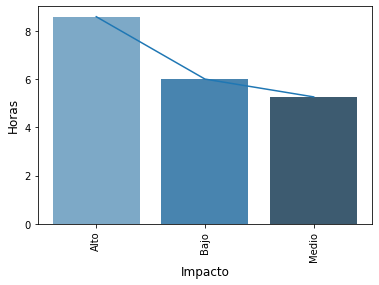

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_impacto.index, epm_by_impacto.values, palette="Blues_d")
plt.xticks(range(len(epm_by_impacto)), epm_by_impacto.index, rotation="vertical")
ax.plot(range(len(epm_by_impacto)), epm_by_impacto.values)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Impacto', fontsize=12);

In [ ]:
epm_by_motivo = epm.groupby('Motivo').mean()['Horas'].sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


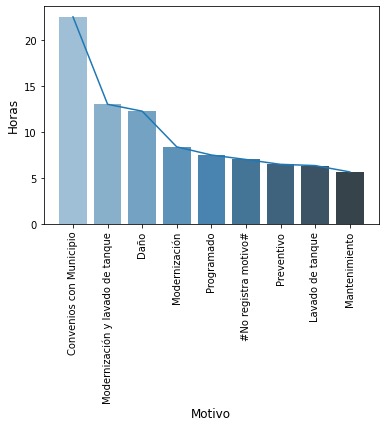

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_motivo.index, epm_by_motivo.values, palette="Blues_d")
plt.xticks(range(len(epm_by_motivo)), epm_by_motivo.index, rotation="vertical")
ax.plot(range(len(epm_by_motivo)), epm_by_motivo.values)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Motivo', fontsize=12);

##Punto #2

Variables referente a localización (sector):

*  Municipio
*   Circuito
*   Barrio





### Municipio

In [ ]:
epm_by_municipio = epm.groupby('Municipio').mean()['Horas'].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(40,30))
var = 'Municipio'
data = pd.concat([epm['Horas'], epm[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Horas', data=data)
fig.axis(ymin=0, ymax=40)
plt.xticks(range(len(epm_by_municipio)), epm['Municipio'].unique(), rotation="vertical");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


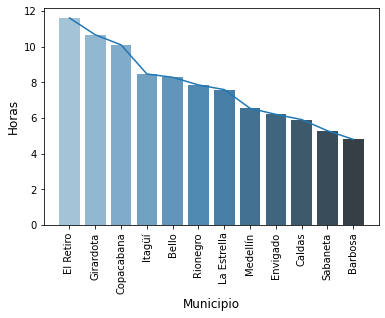

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_municipio.index, epm_by_municipio.values, palette="Blues_d")
plt.xticks(range(len(epm_by_municipio)), epm_by_municipio.index, rotation="vertical")
ax.plot(range(len(epm_by_municipio)), epm_by_municipio.values)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Municipio', fontsize=12);

### Circuito

In [155]:
def add_value_label(x_list,y_list):
    for i in range(0, len(x_list)):
        plt.text(i, y_list[i]/2, format(y_list[i], '0.3f'), fontsize=10, ha = "center")

In [ ]:
epm_by_circuito = epm.groupby('Circuito').mean()['Horas'].sort_values(ascending=False)

In [ ]:
epm_by_circuito_head = epm.groupby('Circuito').mean()['Horas'].sort_values(ascending=False).head(6)

In [ ]:
plt.figure(figsize=(60,30))
var = 'Circuito'
data = pd.concat([epm['Horas'], epm[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Horas', data=data)
fig.axis(ymin=0, ymax=30)
plt.xticks(range(len(epm_by_circuito)), epm['Circuito'].unique(), rotation="vertical");

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_circuito_head.index, epm_by_circuito_head.values, palette="Blues_d")
plt.xticks(range(len(epm_by_circuito_head)), epm_by_circuito_head.index, rotation="vertical")
ax.scatter(range(len(epm_by_circuito_head)), epm_by_circuito_head)
add_value_label(range(len(epm_by_circuito_head)),epm_by_circuito_head)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Circuito', fontsize=12);

In [ ]:
epm_by_circuito_tail = epm.groupby('Circuito').mean()['Horas'].sort_values(ascending=False).tail(6).sort_values(ascending=True)

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_circuito_tail.index, epm_by_circuito_tail.values, palette="Blues_d")
plt.xticks(range(len(epm_by_circuito_tail)), epm_by_circuito_tail.index, rotation="vertical")
ax.scatter(range(len(epm_by_circuito_tail)), epm_by_circuito_tail)
add_value_label(range(len(epm_by_circuito_tail)),epm_by_circuito_tail)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Circuito', fontsize=12);

### Barrio

In [ ]:
epm_by_barrio_head = epm.groupby('Barrio').mean()['Horas'].sort_values(ascending=False).head(6)
epm_by_barrio_tail = epm.groupby('Barrio').mean()['Horas'].sort_values(ascending=False).tail(6)

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_barrio_head.index, epm_by_barrio_head.values, palette="Blues_d")
plt.xticks(range(len(epm_by_barrio_head)), epm_by_barrio_head.index, rotation="vertical")
ax.scatter(range(len(epm_by_barrio_head)), epm_by_barrio_head)
add_value_label(range(len(epm_by_barrio_head)),epm_by_barrio_head)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Barrio', fontsize=12);

In [ ]:
fig, ax = plt.subplots()
sns.barplot(epm_by_barrio_tail.index, epm_by_barrio_tail.values, palette="Blues_d")
plt.xticks(range(len(epm_by_barrio_tail)), epm_by_barrio_tail.index, rotation="vertical")
ax.scatter(range(len(epm_by_barrio_tail)), epm_by_barrio_tail)
add_value_label(range(len(epm_by_barrio_tail)),epm_by_barrio_tail)
plt.ylabel('Horas', fontsize=12)
plt.xlabel('Barrio', fontsize=12);

##Punto #3

In [ ]:
tabla_municipio = pd.DataFrame(columns=['Municipio', 'Max', 'Min', 'Promedio', 'Varianza'])
tabla_circuito = pd.DataFrame(columns=['Circuito', 'Max', 'Min', 'Promedio', 'Varianza'])

In [ ]:
#Municipio
for i in epm['Municipio'].unique():
  datos = np.array(epm[(epm['Municipio'] == i)]['Horas'])
  try:
    max = datos.max()
    min = datos.min()
    promedio = np.mean(datos)
    varianza = datos.var()
  except ValueError:
    pass
  tabla_municipio = tabla_municipio.append({'Municipio' : str(i) , 'Max' : float(round(max,2)), 'Min' : float(round(min,2)), 
                                            'Promedio': float(round(promedio,2)), 'Varianza': float(round(varianza,2))} , ignore_index=True)

In [ ]:
tabla_municipio

In [ ]:
#Circuito
for i in epm['Circuito'].unique():
  datos = np.array(epm[(epm['Circuito'] == i)]['Horas'])
  try:
    max = datos.max()
    min = datos.min()
    promedio = np.mean(datos)
    varianza = datos.var()
  except ValueError:
    pass
  tabla_circuito = tabla_circuito.append({'Circuito' : str(i) , 'Max' : float(round(max,2)), 'Min' : float(round(min,2)), 
                                          'Promedio': float(round(promedio,2)), 'Varianza': float(round(varianza,2))} , ignore_index=True)

In [ ]:
tabla_circuito

## Heatmap / Folium

### Heatmap horas intervención (OP1)

In [ ]:
#Dirección completa solo con Circuito y municipio
epm['Dirección completa2'] = [0 for i in range(len(epm['Municipio']))]
epm['Latitud_ubi2'] = [0 for i in range(len(epm['Municipio']))]
epm['Longitud_ubi2'] = [0 for i in range(len(epm['Municipio']))]
epm['Lati+Longi'] = [0 for i in range(len(epm['Municipio']))]

In [ ]:
epm = epm.astype({'Dirección completa2' : 'object', 'Latitud_ubi2' : 'object', 'Longitud_ubi2' : 'object', 'Lati+Longi' : 'object'})

In [ ]:
for i, row in epm.iterrows():
  apiAddress = (str(epm.at[i,'Circuito'])+','+str(epm.at[i,'Municipio']+',Antioquia,Colombia'))
  epm.at[i,'Dirección completa2'] = apiAddress

  parameters = {"key": "6SVccLzFrvBJqpGguwZJMgY6mDppOrAo", 
                "location": apiAddress}

  response = requests.get("http://www.mapquestapi.com/geocoding/v1/address", params=parameters)
  data = response.text
  dataJ = json.loads(data)['results']
  lat = (dataJ[0]['locations'][0]['latLng']['lat'])
  lng = (dataJ[0]['locations'][0]['latLng']['lng'])
  
  #Agregar resultados al DF epm:
  epm.at[i,'Latitud_ubi2'] = lat
  epm.at[i,'Longitud_ubi2'] = lng

In [ ]:
# Calcular el promedio de las Latitudes y longitudes para plantear el mapa base
meanLong2 = -75.567
meanLat2 = 6.217

print(meanLong2, meanLat2);

# Crear mapa base
mapObj2 = folium.Map(location=[meanLat2, meanLong2], zoom_start = 12.5)

# Crear capa de heatmap
colrGradient = {0.4: 'blue', 0.6: 'yellow', 0.8: 'red'}

heatmap2 = HeatMap(list(zip(epm['Latitud_ubi2'], epm['Longitud_ubi2'], epm['Horas'])),
                   min_opacity=0.2,
                   max_val = epm['Horas'].max(),
                   radius = 50, blur = 60, 
                   max_zoom = 1,
                   gradient = colrGradient,
                   overlay = True)
# Agregar la capa de heatmap al mapa base
heatmap2.add_to(mapObj2)
mapObj2

-75.567 6.217


In [ ]:
mapObj2.save("Heatmap1.html")

### Heatmap horas intervención (OP2)

In [ ]:
for i, row in epm.iterrows():
  a = ('(' + str(epm.at[i,'Latitud_ubi2']) + ',' + str(epm.at[i,'Longitud_ubi2']) + ')')
  epm.at[i,'Lati+Longi'] = a

In [ ]:
tabla_mapadecalor = pd.DataFrame(columns=['Lati+Longi', 'Latitud', 'Longitud', 'Horas_prom'])
tabla_mapadecalor = tabla_mapadecalor.astype({'Latitud' : 'float32', 'Longitud' : 'float32', 'Horas_prom' : 'float32'}) 

In [ ]:
for i in epm['Lati+Longi'].unique():
  datos = np.array(epm[(epm['Lati+Longi'] == i)]['Horas'])
  try:
    prom = np.mean(datos)
    parte = i.split(',')
    lat = parte[0][1:7]
    lon = parte[1][0:7]
  except ValueError:
    pass
  tabla_mapadecalor = tabla_mapadecalor.append({'Lati+Longi' : str(i) , 'Latitud' : np.float32(lat), 'Longitud' : np.float32(lon), 
                                            'Horas_prom': np.float32(prom)} , ignore_index=True)

In [ ]:
tabla_mapadecalor.dtypes

In [ ]:
meanLong3 = -75.567
meanLat3 = 6.217

print(meanLong3, meanLat3);

# Crear mapa base
mapObj3 = folium.Map(location=[meanLat3, meanLong3], zoom_start = 12.5)

# Crear capa de heatmap
colrGradient = {0.3: 'blue', 0.6: 'yellow', 0.7: 'red'}

heatmap3 = HeatMap(list(zip(tabla_mapadecalor['Latitud'], tabla_mapadecalor['Longitud'], tabla_mapadecalor['Horas_prom'])),
                   min_opacity=0.6,
                   max_val = tabla_mapadecalor['Horas_prom'].max(),
                   radius = 50, blur = 60, 
                   max_zoom = 1,
                   gradient = colrGradient,
                   overlay = True)
# Agregar la capa de heatmap al mapa base
heatmap3.add_to(mapObj3)
mapObj3

In [ ]:
mapObj3.save("Heatmap2.html")

## Forecast

#### Preproceso

In [7]:
epmfore = epm[['Impacto', 'Motivo', 'Número de instalación', 'Municipio', 'Horas']]

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor

In [9]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(epmfore['Motivo'])
print(list(label_encoder.classes_))
epmfore.Motivo = label_encoder.transform(epmfore["Motivo"])

['#No registra motivo#', 'Convenios con Municipio', 'Daño', 'Lavado de tanque', 'Mantenimiento', 'Modernización', 'Modernización y lavado de tanque', 'Preventivo', 'Programado']


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(epmfore['Impacto'])
print(list(label_encoder.classes_))
epmfore.Impacto = label_encoder.transform(epmfore["Impacto"])

['Alto', 'Bajo', 'Medio']


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(epmfore['Municipio'])
print(list(label_encoder.classes_))
epmfore.Municipio = label_encoder.transform(epmfore["Municipio"])

['Barbosa', 'Bello', 'Caldas', 'Copacabana', 'El Retiro', 'Envigado', 'Girardota', 'Itagüí', 'La Estrella', 'Medellín', 'Rionegro', 'Sabaneta']


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
epmfore.dtypes

Impacto                    int64
Motivo                     int64
Número de instalación      int32
Municipio                  int64
Horas                    float32
dtype: object

#### División del set de datos

In [103]:
epmfore = epmfore.astype({'Impacto' : 'int', 'Motivo' : 'int', 'Municipio' : 'int'})

In [104]:
X = epmfore.values[:,:-1]
y = epmfore['Horas'].values
print(X.shape, y.shape)

(999, 4) (999,)


In [105]:
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(699, 4) (699,) (300, 4) (300,)


#### Modelo 1: Linear Regression

In [106]:
lr = LinearRegression()
lr.fit(Xtr, ytr)
lr.score(Xtr, ytr), lr.score(Xts, yts)

(0.09202899448752344, 0.1733816861607913)

In [17]:
r2_score(yts, lr.predict(Xts))

0.13888882526862434

In [18]:
median_absolute_error(yts, lr.predict(Xts))

1.8503461114940336

In [19]:
def rel_mrae(estimator, X, y):
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

In [20]:
rel_mrae(lr, Xtr, ytr), rel_mrae(lr, Xts, yts)

(0.451740987436873, 0.4072169988342645)

In [21]:
preds = lr.predict(Xts)
errors = np.abs(preds-yts)/yts

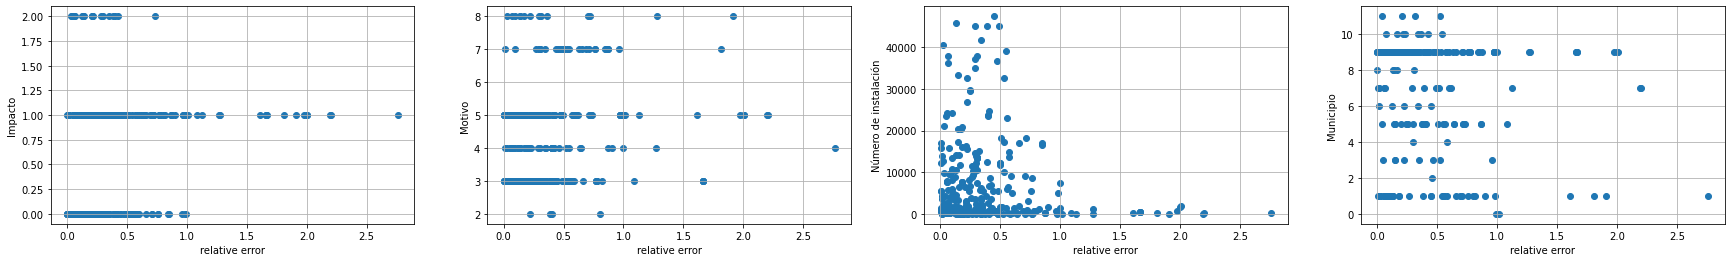

In [22]:
plt.figure(figsize=(30,4))
cols = ["Impacto","Motivo","Número de instalación", "Municipio"]
for i,col in enumerate(cols):
    plt.subplot(1,len(cols),i+1)
    plt.scatter(errors, Xts[:,i])
    plt.ylabel(col)
    plt.xlabel("relative error")
    plt.grid();

In [23]:
epmfore.dtypes

Impacto                    int64
Motivo                     int64
Número de instalación      int32
Municipio                  int64
Horas                    float32
dtype: object

In [24]:
corrcoefs = pd.DataFrame([np.corrcoef(Xts[:,i], errors)[0,1] for i in range(len(cols))], index=cols, columns=["corrcoef"])
corrcoefs

,corrcoef
Impacto,0.169615
Motivo,0.133645
Número de instalación,-0.176076
Municipio,-0.159245


In [25]:
from progressbar import progressbar as pbar

def bootstrap_score(estimator, X, y, test_size):
  trscores, tsscores = [], []
  for _ in range(10):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size = test_size)
    estimator.fit(Xtr, ytr)
    trscores.append(rel_mrae(estimator, Xtr, ytr))
    tsscores.append(rel_mrae(estimator, Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

In [144]:
modelos = pd.DataFrame(columns=['Modelo', 'Train score', 'Test score'])

In [145]:
estimator = LinearRegression() #Este sera el modelo de ML  a ajustar (Linear Regression)
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, X, y, test_size=0.3)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))
modelos = modelos.append({'Modelo': 'Linear Regression', 'Train score': trmean, 'Test score': tsmean}, ignore_index=True)

train score 0.424 (±0.0079)
test score  0.438 (±0.0281)


#### Modelo 2: DecisionTreeRegressor

In [146]:
estimator2 = DecisionTreeRegressor(max_depth=5) #Este sera el modelo de ML  a ajustar (Decision Tree Regressor)
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator2, X, y, test_size=0.3)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))
modelos = modelos.append({'Modelo': 'DTR depth = 5', 'Train score': trmean, 'Test score': tsmean}, ignore_index=True)

train score 0.338 (±0.0089)
test score  0.396 (±0.0266)


In [147]:
estimator3 = c(max_depth=10) #Este sera el modelo de ML  a ajustar (Decision Tree Regressor)
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator3, X, y, test_size=0.3)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))
modelos = modelos.append({'Modelo': 'DTR depth = 10', 'Train score': trmean, 'Test score': tsmean}, ignore_index=True)

train score 0.177 (±0.0191)
test score  0.405 (±0.0365)


#### Modelo 3: RandomForestRegressor

In [180]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(max_depth=20)
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, eX, ey, test_size=0.3)
print("train score %.3f (±%.4f)"%(trmean, trstd))
print("test score  %.3f (±%.4f)"%(tsmean, tsstd))
modelos = modelos.append({'Modelo': 'RFR depth = 8', 'Train score': trmean, 'Test score': tsmean}, ignore_index=True)

train score 0.155 (±0.0053)
test score  0.384 (±0.0358)


In [164]:
modelos_sort = modelos.groupby('Modelo').mean()['Test score'].sort_values(ascending=True)

In [167]:
modelos.sort_values(by=('Test score'), ascending = True)

,Modelo,Train score,Test score
3,RFR depth = 8,0.264042,0.385002
1,DTR depth = 5,0.337599,0.396223
2,DTR depth = 10,0.177441,0.404538
0,Linear Regression,0.424290,0.437725


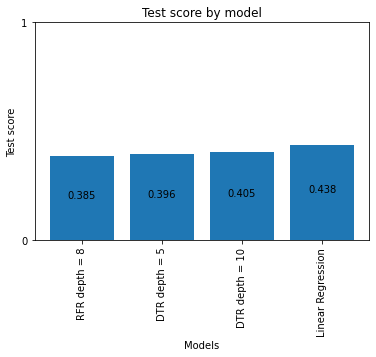

In [166]:
plt.ylabel('Test score')
plt.xlabel('Models')
plt.xticks(range(len(modelos_sort)), modelos_sort.index, rotation="vertical")
plt.bar(modelos_sort.index, modelos_sort.values)
add_value_label(range(len(modelos_sort.values)),modelos_sort.values)
plt.yticks(range(0,2))
plt.title('Test score by model')
plt.show()

#### Performance associated with Model 3 (Our best option)



In [172]:
from sklearn.model_selection import cross_validate, ShuffleSplit
estimator =  RandomForestRegressor(max_depth=8)
modeloforecast = cross_validate(estimator, X, y, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))

In [173]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))

In [174]:
eX = epmfore.values[:,:-1]
ey = epmfore['Horas'].values
print(eX.shape, ey.shape)

(999, 4) (999,)


In [175]:
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(eX, ey, test_size=test_size)
print (Xtv.shape, Xts.shape)

(699, 4) (300, 4)


In [176]:
scores = [rel_mrae(estimator, eX, ey) for estimator in modeloforecast["estimator"]]
print ("scores", scores)
print ("mean score %.3f (±%.4f) with %d splits"%(np.mean(scores), np.std(scores), len(scores)))

scores [0.27674821868469585, 0.2781322813692526, 0.2756033946385669, 0.2804081020104497, 0.28180430039362836, 0.2859756700615705, 0.2774088135275529, 0.281008748849255, 0.2828198651065397, 0.28159080112872564]
mean score 0.280 (±0.0030) with 10 splits


In [177]:
zscores = []
estimators = [estimator, estimator2, estimator3]
for estimator in estimators:
    print("--")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(z["test_score"]))
best = np.argmin(zscores)
print ("selecting ", best)
best_estimator = estimators[best]
print ("\nselected model")
print (best_estimator)

--
test score   0.385 (±0.0276) with 10 splits
train score  0.241 (±0.0200) with 10 splits
--
test score   0.422 (±0.0363) with 10 splits
train score  0.330 (±0.0144) with 10 splits
--
test score   0.458 (±0.0582) with 10 splits
train score  0.148 (±0.0345) with 10 splits
selecting  0

selected model
RandomForestRegressor(max_depth=8)


In [178]:
best_estimator.fit(Xtv,ytv)
reported_performance = rel_mrae(best_estimator, Xts, yts)
print ("reported performance of selectd model %.3f"%reported_performance)

reported performance of selectd model 0.373


### Diagnosing
**Random Forest BASELINE**

In [49]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="test score")

    plt.legend(loc="best")

In [51]:
from sklearn.model_selection import ShuffleSplit, KFold,cross_val_score
from sklearn.model_selection import learning_curve

In [159]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(max_depth=8)
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, eX, ey, test_size=0.3)
print("train score %.3f (±%.4f)"%(trmean, trstd))
print("test score  %.3f (±%.4f)"%(tsmean, tsstd))

train score 0.261 (±0.0104)
test score  0.375 (±0.0244)


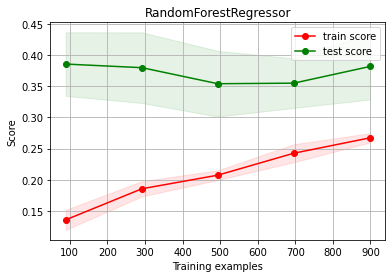

In [57]:
plot_learning_curve(estimator, estimator.__class__.__name__, eX, ey, cv = KFold(n_splits=10), scoring=rel_mrae)